# Cluster

In [1]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
#XRD Ensemble
#28 4NPQ
#18 4HFI

In [3]:
traj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
traj.superpose(traj,28)

<mdtraj.Trajectory with 33 frames, 1540 atoms, 1540 residues, without unitcells at 0x7ffa84c0afd0>

In [71]:
def rmsd_cluster(traj_note,skip=10):
    location = '/media/scottzhuang/data/MD/'
    top_location = traj_note + ".ca.gro"
    traj_name = traj_note + ".skip" + str(skip) + ".ca.xtc"    
    traj = md.load(location + traj_location,top= location +top_location)
    traj.superpose(traj,0)
    distances = np.empty((traj.n_frames, traj.n_frames))
    for i in range(traj.n_frames):
        distances[i] = md.rmsd(traj, traj, i)
    print('Max pairwise rmsd: %f nm' % np.max(distances))
    reduced_distances = squareform(distances, checks=False)
    linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')
    plt.title('RMSD Average linkage hierarchical clustering')
    _ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

Max pairwise rmsd: 0.271595 nm


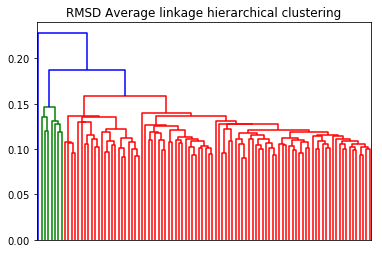

In [67]:
rmsd_cluster("5NJY_pH70_md1/5NJY_pH70_md1")

Max pairwise rmsd: 0.281853 nm


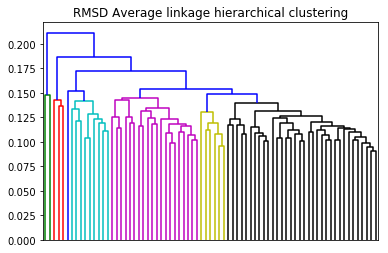

In [68]:
rmsd_cluster("5NJY_pH70_md2/5NJY_pH70_md2")

Max pairwise rmsd: 0.204397 nm


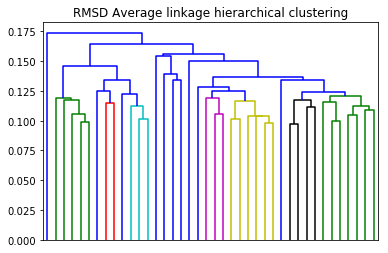

In [69]:
rmsd_cluster("5NJY_pH70_md3/5NJY_pH70_md3")

Max pairwise rmsd: 0.271595 nm


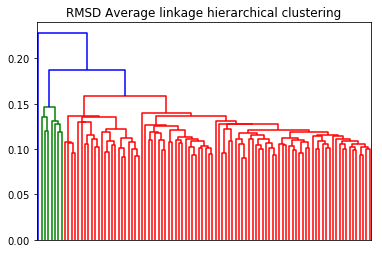

In [72]:
rmsd_cluster("5NJY_pH46_md1/5NJY_pH46_md1",skip=1)